# Big Data Analysis using PySpark

COMPANY: CODTECH IT SOLUTIONS

NAME: YAKKALA LAHARI

INTERN ID: CT04DY2623

DOMAIN: DATA ANALYTICS

DURATION: 4 WEEKS

MENTOR: NEELA SANTHOSH

In [1]:
import os
import urllib.request
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, hour, desc, to_timestamp
import matplotlib.pyplot as plt
import pandas as pd

## Setup and Dataset Download

In [2]:
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

PARQUET_URL = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
PARQUET_LOCAL = os.path.join(DATA_DIR, 'yellow_tripdata_2023-01.parquet')

if not os.path.exists(PARQUET_LOCAL):
    print('Downloading dataset...')
    urllib.request.urlretrieve(PARQUET_URL, PARQUET_LOCAL)
    print('Download complete.')
else:
    print('Dataset already available locally.')

Dataset already available locally.


## Initialize Spark Session

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = (
    SparkSession.builder
    .appName("BigData_PySpark_Analysis")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

print("Spark Session Created:", spark.sparkContext.appName)


Spark Session Created: BigData_PySpark_Analysis


## Load and Explore Dataset

In [4]:
df = spark.read.parquet(PARQUET_LOCAL)
print('Dataset Loaded Successfully')
df.printSchema()
df.show(5)

Dataset Loaded Successfully
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+--------

## Data Cleaning and Preprocessing

In [5]:
df = df.dropna(subset=['tpep_pickup_datetime', 'trip_distance', 'fare_amount'])
df = df.filter((col('trip_distance') > 0) & (col('fare_amount') > 0))
df = df.withColumn('tpep_pickup_datetime', to_timestamp('tpep_pickup_datetime'))
print('Cleaned dataset:')
print('Total Records:', df.count())

Cleaned dataset:
Total Records: 2998382


## Exploratory Data Analysis (EDA)

In [6]:
# Trips by pickup hour
df = df.withColumn('pickup_hour', hour(col('tpep_pickup_datetime')))
trips_by_hour = df.groupBy('pickup_hour').agg(count('*').alias('trip_count')).orderBy('pickup_hour')
trips_by_hour.show(24)

# Average fare by passenger count
avg_fare = df.groupBy('passenger_count').agg(avg('fare_amount').alias('avg_fare'), count('*').alias('count')).orderBy('passenger_count')
avg_fare.show()

# Top 10 pickup locations
top_pu = df.groupBy('PULocationID').agg(count('*').alias('trips')).orderBy(desc('trips')).limit(10)
top_pu.show()

+-----------+----------+
|pickup_hour|trip_count|
+-----------+----------+
|          0|     82723|
|          1|     58102|
|          2|     40715|
|          3|     26354|
|          4|     16816|
|          5|     17091|
|          6|     42508|
|          7|     84885|
|          8|    114479|
|          9|    128442|
|         10|    140715|
|         11|    151018|
|         12|    166249|
|         13|    174835|
|         14|    187495|
|         15|    192125|
|         16|    191473|
|         17|    205090|
|         18|    211550|
|         19|    188975|
|         20|    162326|
|         21|    158318|
|         22|    144309|
|         23|    111789|
+-----------+----------+

+---------------+------------------+-------+
|passenger_count|          avg_fare|  count|
+---------------+------------------+-------+
|           NULL|21.186763601812338|  64201|
|            0.0|16.168202510359798|  49953|
|            1.0|18.074408467255598|2213563|
|            2.0| 20.40332980

## Visualization (Matplotlib + Pandas)

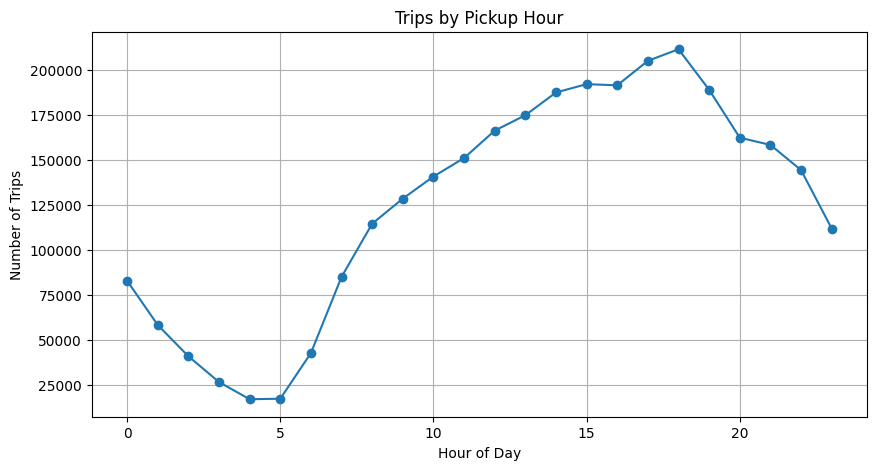

In [7]:
# Convert Spark DF to Pandas
trips_by_hour_pdf = trips_by_hour.toPandas()
avg_fare_pdf = avg_fare.toPandas()

plt.figure(figsize=(10,5))
plt.plot(trips_by_hour_pdf['pickup_hour'], trips_by_hour_pdf['trip_count'], marker='o')
plt.title('Trips by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

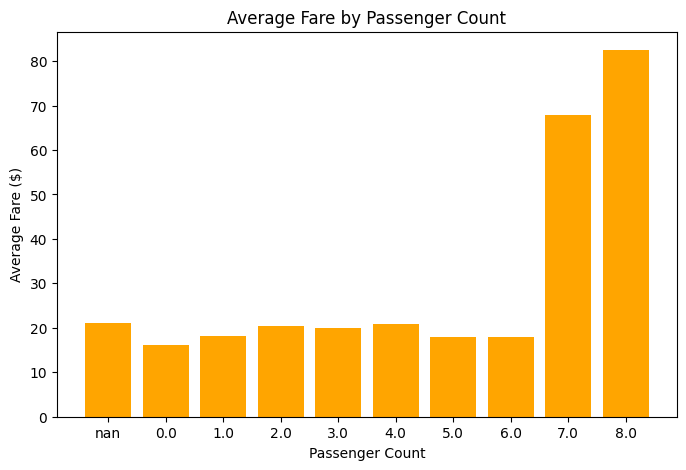

In [8]:
plt.figure(figsize=(8,5))
plt.bar(avg_fare_pdf['passenger_count'].astype(str), avg_fare_pdf['avg_fare'], color='orange')
plt.title('Average Fare by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare ($)')
plt.show()

## Save Summary Results

In [9]:
out_dir = './results'
os.makedirs(out_dir, exist_ok=True)
avg_fare_pdf.to_csv(os.path.join(out_dir, 'avg_fare_summary.csv'), index=False)
print('Results saved to results/avg_fare_summary.csv')

Results saved to results/avg_fare_summary.csv


## Conclusion

- Demonstrated how PySpark handles and processes large-scale datasets efficiently.
- Analyzed NYC Taxi data for patterns in trip times, passenger count, and fare.
- Created visual insights and stored summary results.

## Thank You